In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
import datetime
# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
# from xgboost import XGBClassifier
# import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
from tqdm import tqdm
print(os.listdir("../input/ieee-fraud-detection"))

['train_identity.csv', 'test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        #print(col_type)
        if str(col_type)[:4]== 'date' : continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train = pd.read_pickle('../input/datas2/train.pkl')
test  = pd.read_pickle('../input/datas2/test.pkl')
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

In [4]:
print(train.shape)

(590540, 421)


In [5]:
print('Memory usage of train is {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Memory usage of test is {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Memory usage of train is 660.07 MB
Memory usage of test is 573.60 MB


In [6]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    print("delete temp_df")
    del temp_df
    gc.collect()
    return train_df, test_df

In [7]:
train = train.drop(['card_id'], axis =1)
test = test.drop(['card_id'], axis =1)

In [8]:
# train['card4'].value_counts( dropna=False)
# 5자리 해외겸용
train['card1_len']= train['card1'].map(lambda x : len(str(x)))
test['card1_len']= test['card1'].map(lambda x : len(str(x)))

# train['card1']

In [9]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

train['uid4'] = train['uid3'].astype(str)+'_'+train['P_emaildomain'].astype(str)
test['uid4'] = test['uid3'].astype(str)+'_'+test['P_emaildomain'].astype(str)

train['uid5'] = train['uid3'].astype(str)+'_'+train['R_emaildomain'].astype(str)
test['uid5'] = test['uid3'].astype(str)+'_'+test['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
# remove_features += new_columns

print('#'*10)
print('Most common uIds:')
# for col in new_columns:
#     print('#'*10, col)
#     print(train[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train, test = frequency_encoding(train, test, i_cols, self_encoding=False)


##########
Most common uIds:
delete temp_df


In [10]:
print('Memory usage of train is {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Memory usage of test is {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Memory usage of train is 705.23 MB
Memory usage of test is 612.36 MB


In [11]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in tqdm(main_columns):  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   
                
                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
            del temp_df
            gc.collect()
    return train_df, test_df

# def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
#     for main_column in main_columns:  
#         for col in uids:
            
#             new_norm_col_name = col+'_'+main_column+'_std_norm'
#             norm_cols = []
            
#             for agg_type in aggregations:
#                 new_col_name = col+'_'+main_column+'_'+agg_type
#                 temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
#                 temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
#                                                         columns={agg_type: new_col_name})

#                 temp_df.index = list(temp_df[col])
#                 temp_df = temp_df[new_col_name].to_dict()   

#                 train_df[new_col_name] = train_df[col].map(temp_df)
#                 test_df[new_col_name]  = test_df[col].map(temp_df)
#                 norm_cols.append(new_col_name)
            
#             train_df[new_norm_col_name] = (train_df[main_column]-train_df[norm_cols[0]])/train_df[norm_cols[1]]
#             test_df[new_norm_col_name]  = (test_df[main_column]-test_df[norm_cols[0]])/test_df[norm_cols[1]]          
            
#             del train_df[norm_cols[0]], train_df[norm_cols[1]]
#             del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
#     return train_df, test_df

In [12]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max train_df values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
i_cols.remove('D7')
i_cols += ['TransactionAmt'] ## 커널이 죽는다
# i_cols += ['isFraud']
uids = ['uid','uid2','uid3','uid4','uid5']  #'card1','card2','card3','card5' 추가하면 커널 죽음
aggregations = ['mean','std']

####### uIDs aggregations
train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

100%|██████████| 15/15 [05:08<00:00, 26.19s/it]


In [13]:
print('Memory usage of train is {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Memory usage of test is {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Memory usage of train is 1381.04 MB
Memory usage of test is 1192.22 MB


In [14]:
print(train.shape)

(590540, 581)


In [15]:
# # 최악의 Overfit이다.
# main_column = 'isFraud'
# uids = ['uid','uid2','uid3','uid4','uid5']
# for col in tqdm(uids) :
#     for agg_type in ['mean','std']:
#         new_col_name = col+'_'+main_column+'_'+agg_type
# #         temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
#         temp_df = train.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
#                                                 columns={agg_type: new_col_name})

#         temp_df.index = list(temp_df[col])
#         temp_df = temp_df[new_col_name].to_dict()   
# #         print(temp_df)
#         train[new_col_name] = train[col].map(temp_df)
#         test[new_col_name]  = test[col].map(temp_df)
#         train[new_col_name] = train[new_col_name].fillna(0)
#         test[new_col_name]  = test[new_col_name].fillna(0)

In [16]:
# for col in ['ProductCD','M4']:
#     temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
#                                                         columns={'mean': col+'_target_mean'})
#     temp_dict.index = temp_dict[col].values
#     temp_dict = temp_dict[col+'_target_mean'].to_dict()

#     train[col+'_target_mean'] = train[col].map(temp_dict).astype('float16')
#     test[col+'_target_mean']  = test[col].map(temp_dict).astype('float16')

In [17]:
import datetime
train['DayOfYear'] = train['TransactionDT'].dt.dayofyear
test['DayOfYear'] = test['TransactionDT'].dt.dayofyear


In [18]:
train = train.drop(['day'], axis = 1)
test = test.drop(['day'], axis = 1)

In [19]:
# for df in [train, test]:
#     ########################### Device info
#     df['DeviceInfo'] = df['DeviceInfo'].cat.add_categories("unknown_device").fillna('unknown_device').str.lower()
#     df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
#     df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
#     ########################### Device info 2
#     df['id_30'] = df['id_30'].cat.add_categories("unknown_device").fillna('unknown_device').str.lower()
#     df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
#     df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
#     ########################### Browser
#     df['id_31'] = df['id_31'].cat.add_categories("unknown_device").fillna('unknown_device').str.lower()
#     df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [20]:
# emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
# us_emails = ['gmail', 'net', 'edu']

In [21]:
# # https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499

# for c in ['P_emaildomain', 'R_emaildomain']:
#     train[c + '_bin'] = train[c].map(emails)
#     test[c + '_bin'] = test[c].map(emails)
    
#     train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
#     test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
#     train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
#     test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [22]:
train.to_pickle('train2.pkl')
test.to_pickle('test2.pkl')
# sample_submission.to_pickle('sample_submission.pkl')

In [23]:
Y_train = train['isFraud'].copy()

X_train = train.drop('isFraud', axis=1)
print(X_train.shape)
X_train.drop('TransactionDT', axis=1, inplace=True)
print(X_train.shape)
X_test = test.drop('TransactionDT', axis=1) 
print(X_test.shape)

(590540, 580)
(590540, 579)
(506691, 579)


In [24]:
# X_train =X_train.fillna(-999)


In [25]:
numerical_columns = list(X_train.select_dtypes(include=['float16','float32','float64','int8','int16','int64']).columns)

#list(test.select_dtypes(exclude=['object']).columns)
print(X_train.shape)
X_train[numerical_columns] =X_train[numerical_columns].fillna(X_train[numerical_columns].median())
X_test[numerical_columns] =X_test[numerical_columns].fillna(X_train[numerical_columns].median())
print("filling numerical columns null values done")
print(X_train.shape)

(590540, 579)
filling numerical columns null values done
(590540, 579)


In [26]:
categorical_columns = list(filter(lambda x: x not in numerical_columns, list(X_train.columns)))
categorical_columns[:5]
X_train[categorical_columns] =X_train[categorical_columns].fillna(X_train[categorical_columns].mode())
X_test[categorical_columns] =X_test[categorical_columns].fillna(X_train[categorical_columns].mode())
print("filling numerical columns null values done")

filling numerical columns null values done


In [27]:
# # 다중공선성 제거

# threshold = 0.98
    
# # Absolute value correlation matrix
# corr_matrix = X_train.corr().abs()

# # Getting the upper triangle of correlations
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Select columns with correlations above threshold
# to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# print('There are %d columns to remove.' % (len(to_drop)))
# print(to_drop)
# X_train = X_train.drop(columns = to_drop)
# X_test = X_test.drop(columns = to_drop)
# del upper
# gc.collect()

In [28]:
# # X_train['addr1_bin'] = 
# X_train['addr1_bin'] =X_train['addr1'].map(lambda x: 1 if x>270 and x<320 else 0)
# X_train['C2_bin'] =X_train['C2'].map(lambda x: 1 if x>200 else 0)
# X_train['V15_bin'] =X_train['V15'].map(lambda x: 1 if x<1 else 0)
# X_train['V16_bin'] =X_train['V16'].map(lambda x: 1 if x<1 else 0)
# X_train['V17_bin'] =X_train['V17'].map(lambda x: 1 if x<1 else 0)
# X_train['V18_bin'] =X_train['V18'].map(lambda x: 1 if x<1 else 0)
# X_train['V21_bin'] =X_train['V21'].map(lambda x: 1 if x<1 else 0)
# X_train['V22_bin'] =X_train['V22'].map(lambda x: 1 if x<1 else 0)
# X_train['V31_bin'] =X_train['V31'].map(lambda x: 1 if x<1 else 0)
# X_train['V32_bin'] =X_train['V32'].map(lambda x: 1 if x<1 else 0)
# X_train['V33_bin'] =X_train['V33'].map(lambda x: 1 if x<1 else 0)
# X_train['V34_bin'] =X_train['V34'].map(lambda x: 1 if x<1 else 0)
# X_train['V39_bin'] =X_train['V39'].map(lambda x: 1 if x<1 else 0)
# X_train['V42_bin'] =X_train['V42'].map(lambda x: 1 if x<1 else 0)
# X_train['V43_bin'] =X_train['V43'].map(lambda x: 1 if x<1 else 0)
# X_train['V50_bin'] =X_train['V50'].map(lambda x: 1 if x<1 else 0)
# X_train['V51_bin'] =X_train['V21'].map(lambda x: 1 if x<1 else 0)
# X_train['V52_bin'] =X_train['V21'].map(lambda x: 1 if x<1 else 0)

# # X_test['addr1_bin'] = 
# X_test['addr1_bin'] =X_test['addr1'].map(lambda x: 1 if x>270 and x<320 else 0)
# X_test['C2_bin'] =X_test['C2'].map(lambda x: 1 if x>200 else 0)
# X_test['V15_bin'] =X_test['V15'].map(lambda x: 1 if x<1 else 0)
# X_test['V16_bin'] =X_test['V16'].map(lambda x: 1 if x<1 else 0)
# X_test['V17_bin'] =X_test['V17'].map(lambda x: 1 if x<1 else 0)
# X_test['V18_bin'] =X_test['V18'].map(lambda x: 1 if x<1 else 0)
# X_test['V21_bin'] =X_test['V21'].map(lambda x: 1 if x<1 else 0)
# X_test['V22_bin'] =X_test['V22'].map(lambda x: 1 if x<1 else 0)
# X_test['V31_bin'] =X_test['V31'].map(lambda x: 1 if x<1 else 0)
# X_test['V32_bin'] =X_test['V32'].map(lambda x: 1 if x<1 else 0)
# X_test['V33_bin'] =X_test['V33'].map(lambda x: 1 if x<1 else 0)
# X_test['V34_bin'] =X_test['V34'].map(lambda x: 1 if x<1 else 0)
# X_test['V39_bin'] =X_test['V39'].map(lambda x: 1 if x<1 else 0)
# X_test['V42_bin'] =X_test['V42'].map(lambda x: 1 if x<1 else 0)
# X_test['V43_bin'] =X_test['V43'].map(lambda x: 1 if x<1 else 0)
# X_test['V50_bin'] =X_test['V50'].map(lambda x: 1 if x<1 else 0)
# X_test['V51_bin'] =X_test['V21'].map(lambda x: 1 if x<1 else 0)
# X_test['V52_bin'] =X_test['V21'].map(lambda x: 1 if x<1 else 0)


In [29]:
droplst = ['V237',
'id_10',
'V144',
'V198',
'V163',
'V172',
'V185',
'V331',
'V181',
'V336',
'V92',
'V175',
'V158',
'V9',
'V249',
'V84',
'V146',
'id_28',
'V195',
'V194',
'V322',
'V153',
'V235',
'V337',
'V192',
'V155',
'V329',
'V173',
'V22',
'V174',
'V16',
'id_29',
'V247',
'id_12',
'V326','V254',
'V157',
'V15',
'V32',
'V94',
'V193',
'V21',
'V191',
'V31',
'M1',
'V330',
'V334',
'V252',
'id_35',
'V141',
'V196',
'V328',
'V327',
'V142',
'V50',
'V138',
'V269',
'V325',
'V240',
'V1',
'V41',
'V241']

In [30]:
# X_train=X_train.drop(droplst, axis =1)
# X_test=X_test.drop(droplst, axis =1)

In [31]:
for f in X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist():
    lbl = preprocessing.LabelEncoder()
    print(f)
    lbl.fit(list(X_train[f].values) + list(X_test[f].values))
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
id_02__id_20
id_02__D8
D11__DeviceInfo
DeviceInfo__P_emaildomain
P_emaildomain__C2
card2__dist1
card1__card5
card2__id_20
card5__P_emaildomain
addr1__card1
uid
uid2
uid3
uid4
uid5


In [32]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

del train, test
gc.collect()

  2%|▏         | 10/579 [00:00<00:05, 99.95it/s]

Memory usage of dataframe is 1508.49 MB


  2%|▏         | 11/579 [00:00<00:05, 108.88it/s]

Memory usage after optimization is: 975.72 MB
Decreased by 35.3%
Memory usage of dataframe is 1304.88 MB


100%|██████████| 579/579 [00:33<00:00, 17.47it/s]


Memory usage after optimization is: 853.55 MB
Decreased by 34.6%


479

In [33]:
#https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment
#https://www.kaggle.com/niteshx2/beginner-explained-lgb-2-leaves-augment
# Data augmentation
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

        
#     for i in range(t//2):
#         mask = y==0
#         x1 = x[mask].copy()
#         ids = np.arange(x1.shape[0])
#         print(ids)
#         for c in range(x1.shape[1]):
#             np.random.shuffle(ids)
#             x1[:,c] = x1[ids][:,c]            
#             x1= pd.DataFrame(x1).sample(frac=0.3).values            
#         xn.append(x1)

    xs = np.vstack(xs)
#     xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
#     yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs])
    y = np.concatenate([y,ys])
#     x = np.vstack([x,xs,xn])
#     y = np.concatenate([y,ys,yn])
    
    
    return x,y

In [34]:
# Hyperparameter 찾기

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

In [35]:
import multiprocessing
seed=120
def train_model(learning_rate,num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1, lambda_l2,max_bin,min_child_weight):
    print("############## New Run ################")
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': 4,
        'learning_rate': learning_rate,#0.01, # learning rate
        'num_iterations' : 200,#3000,
        #'n_estimators' : 800,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'max_depth': -1,#int(max_depth),
        'bagging_fraction' : bagging_fraction,
        'feature_fraction' : feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'max_bin' : int(max_bin),
        'min_child_weight': min_child_weight,
        'bagging_seed' : 11,
        #'early_stopping_round' : 50,
        'verbose' : -1,
        'seed' :seed
    }
    print("PARAMETERS: ")
    print(f"params  = {params}")
    
    tscv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#KFold(n_splits=5)#StratifiedKFold(n_splits=5)#TimeSeriesSplit(n_splits=3)
    sc = []
#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    for fold_,(train_idx, test_idx) in enumerate(tscv.split(X_train, Y_train)):
#         print( Y_train.iloc[train_idx].head())
        x_train, x_val = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[test_idx]
        
        sc2 =[]
        N = 1
    #         Data Augmentation Test
        print(x_train.shape)
        #X_t, y_t = augment(x_train.values, y_train.values)
#         with multiprocessing.Pool() as pool:
#             X_t = pool.map(reduce_mem_usage, pd.DataFrame(X_t))
       # X_t = reduce_mem_usage(pd.DataFrame(X_t))
        lgb_train = lgb.Dataset(x_train.astype('float32'), label=y_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        
        gc.collect()
        
        for i in range(N):
            
             # augmentation 한 것            
            lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=50)
            y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
            train_score = roc_auc_score(y_train.astype('float32'), y)        
            y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
            score = roc_auc_score(y_val.astype('float32'), y)
            print ("Fold : ", fold_,"Number : ", i, "train_auc : ",train_score,"val_auc : ", score)
            sc2.append(score)
            del lgb_model 
            gc.collect()
        sc.append(np.mean(sc2))
        #############################
#         lgb_train = lgb.Dataset(data=x_train.astype('float32'), label=y_train.astype('float32'))
#         lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        
        
#         lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=500)
#         y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
#         train_score = roc_auc_score(y_train.astype('float32'), y)        
#         y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
#         score = roc_auc_score(y_val.astype('float32'), y)
#         print ("Fold : ", fold_,"train_auc : ",train_score,"val_auc : ", score)
#         sc.append(score)
        
    paralst.append(params)
    scorelst.append(np.mean(sc))
    df_para = pd.DataFrame({"parameter" :paralst,"score":scorelst})
    print(df_para)
    df_para.to_csv('para.csv',index=False)

        
    return np.mean(sc)

bounds = {
    'num_leaves': (1300,1600),#(450, 500),
    'min_data_in_leaf': (0,100),#(100, 150),
    #'max_depth': -1,#(-1, 50), # -> -1
    'learning_rate': (0.005,0.01),#0.006883242363721497,
    'bagging_fraction' : (0.3, 0.5),
    'feature_fraction' : (0.1, 0.4),
    'lambda_l1': (0.3, 0.5),
    'lambda_l2': (0.3, 0.7),
    'max_bin' : (150,255), # 추가
    'min_child_weight': (0.01, 0.05),
}

traintime = False#True
if traintime :
    paralst,scorelst = [],[]
    bo = BayesianOptimization(train_model, bounds, random_state= seed)
    bo.maximize(init_points=3, n_iter=30, acq='ucb', xi=0.0, alpha=1e-6)
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': 4,
        'bagging_seed' : 11,
        'learning_rate':bo.max['params']['learning_rate'],#0.01,
        'n_estimators' : 500,#3000,
        'num_leaves': int(bo.max['params']['num_leaves']),
        'min_data_in_leaf': int(bo.max['params']['min_data_in_leaf']),
        'max_depth': -1,#int(bo.max['params']['max_depth']),
        'bagging_fraction' : bo.max['params']['bagging_fraction'],
        'feature_fraction' : bo.max['params']['feature_fraction'],
        'lambda_l1': bo.max['params']['lambda_l1'],
        'lambda_l2': bo.max['params']['lambda_l2'],
        'max_bin' : bo.max['params']['max_bin'],
        'min_child_weight' :  bo.max['params']['min_child_weight'],
       #'early_stopping_round' : 50,
        'verbose' : -1,
        'seed' :seed

    }
    print(params)

In [36]:
if not traintime :  
     #0.9487
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018903235195922664, 'num_iterations': 10000, 'num_leaves': 1304, 'min_data_in_leaf': 1, 'max_depth': -1, 'bagging_fraction': 0.48133708623585175, 'feature_fraction': 0.3930678252599681, 'lambda_l1': 0.33003972170901036, 'lambda_l2': 0.48380640349706283, 'max_bin': 151, 'min_child_weight': 0.02382942159168059, 'bagging_seed': 11, 'verbose': -1, 'seed': 35} #0.9654
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018236177415832534, 'num_iterations':10000, 'num_leaves': 1598, 'min_data_in_leaf': 3, 'max_depth': -1, 'bagging_fraction': 0.4543823845071219, 'feature_fraction': 0.38901411294365906, 'lambda_l1': 0.3320275264241193, 'lambda_l2': 0.441667319239131, 'max_bin': 150, 'min_child_weight': 0.02892164068243388, 'bagging_seed': 11, 'verbose': -1, 'seed': 120} #0.9651
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018904873086818035, 'num_iterations': 10000, 'num_leaves': 1578, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.48856529593796316, 'feature_fraction': 0.3127401145699429, 'lambda_l1': 0.3433175326027915, 'lambda_l2': 0.4315465577396091, 'max_bin': 253, 'min_child_weight': 0.0479085834818095, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.96485
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.0187731591133625, 'num_iterations': 3000, 'num_leaves': 1598, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.47905338286545424, 'feature_fraction': 0.35087371236650544, 'lambda_l1': 0.4609110771693348, 'lambda_l2': 0.4429443255980836, 'max_bin': 246, 'min_child_weight': 0.037410120970604165, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.96461
    #0.9471 -> 0.9469
  #  params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.014645596881635362, 'num_iterations': 3000, 'num_leaves': 1385, 'min_data_in_leaf': 2, 'max_depth': -1, 'bagging_fraction': 0.38470656275266424, 'feature_fraction': 0.3963200069886693, 'lambda_l1': 0.3620323536611625, 'lambda_l2': 0.35373332136972424, 'max_bin': 154, 'min_child_weight': 0.04295077705493547, 'bagging_seed': 11, 'verbose': -1, 'seed': 12}#0.96069
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.014960621900450888, 'num_iterations': 3000, 'num_leaves': 1395, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.34044595394766747, 'feature_fraction': 0.34214407482513476, 'lambda_l1': 0.4805008954626611, 'lambda_l2': 0.37118265029595326, 'max_bin': 245, 'min_child_weight': 0.029364491351868728, 'bagging_seed': 11, 'verbose': -1, 'seed': 399} #0.960682
    
    
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.009833261038853328, 'num_iterations': 10000, 'num_leaves': 1149, 'min_data_in_leaf': 49, 'max_depth': -1, 'bagging_fraction': 0.3240951596739299, 'feature_fraction': 0.3498407985953037, 'lambda_l1': 0.3501312050658983, 'lambda_l2': 0.31690592587909633, 'max_bin': 161, 'min_child_weight': 0.0114896062770591, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.92151
#     params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.009754414928876673, 'num_iterations': 10000, 'num_leaves': 1143, 'min_data_in_leaf': 35, 'max_depth': -1, 'bagging_fraction': 0.3554679818433634, 'feature_fraction': 0.3402175958274567, 'lambda_l1': 0.34752046110782797, 'lambda_l2': 0.37744033227254215, 'max_bin': 242, 'min_child_weight': 0.03617820556477377, 'bagging_seed': 11, 'verbose': -1, 'seed': 165} #0.921416
    #0.9474 -> 0.9471 -> 0.9492 CV: 0.976609
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.008872937600948674, 'num_iterations': 10000, 'num_leaves': 999, 'min_data_in_leaf': 10, 'max_depth': -1, 'bagging_fraction': 0.4713288697981503, 'feature_fraction': 0.39018895127170683, 'lambda_l1': 0.3510394531977163, 'lambda_l2': 0.3873703557388186, 'max_bin': 254, 'min_child_weight': 0.033084878554612146, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.919813
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.008976158898617054, 'num_iterations': 10000, 'num_leaves': 995, 'min_data_in_leaf': 14, 'max_depth': -1, 'bagging_fraction': 0.4682934735568483, 'feature_fraction': 0.3965931325683636, 'lambda_l1': 0.3760099829112723, 'lambda_l2': 0.3975897064215117, 'max_bin': 254, 'min_child_weight': 0.02847878240902596, 'bagging_seed': 11, 'verbose': -1, 'seed': 277} #0.919887
    #0.9465
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.00898758545742255, 'num_iterations': 10000, 'num_leaves': 924, 'min_data_in_leaf': 14, 'max_depth': -1, 'bagging_fraction': 0.4024823598624291, 'feature_fraction': 0.3208499817534414, 'lambda_l1': 0.46115302747432046, 'lambda_l2': 0.35539565704287, 'max_bin': 250, 'min_child_weight': 0.04355005924028087, 'bagging_seed': 11, 'verbose': -1, 'seed': 399} #0.91827
    #0.9467
    #params ={'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007972931513741082, 'num_iterations': 10000, 'num_leaves': 799, 'min_data_in_leaf': 1, 'max_depth': -1, 'bagging_fraction': 0.4895500948839138, 'feature_fraction': 0.37387418327918154, 'lambda_l1': 0.41482044398244905, 'lambda_l2': 0.5362091922107519, 'min_child_weight': 0.021811137046946497, 'bagging_seed': 11, 'verbose': -1, 'seed': 132} #0.916263
    #Best 0.9469 -> 0.9473 -> 0.9474 -> 0.9492 : Best CV 0.9769
    params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.916033
    
    #0.9468
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007899687615149507, 'num_iterations': 3000, 'num_leaves': 799, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.33041506218684263, 'feature_fraction': 0.35416575497676395, 'lambda_l1': 0.38704306154857826, 'lambda_l2': 0.5178012092942015, 'min_child_weight': 0.026728352023513757, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.916009
    # 0.9467
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007372873282822138, 'num_iterations': 3000, 'num_leaves': 599, 'min_data_in_leaf': 50, 'max_depth': -1, 'bagging_fraction': 0.38244660605863556, 'feature_fraction': 0.44257840443437824, 'lambda_l1': 0.45420352424554195, 'lambda_l2': 0.5105273366387331, 'min_child_weight': 0.04533307349626744, 'bagging_seed': 11, 'verbose': -1, 'seed': 160} #0.9131
    # 0.9465
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007203449399886559, 'num_iterations': 3000, 'num_leaves': 599, 'min_data_in_leaf': 50, 'max_depth': -1, 'bagging_fraction': 0.38525498446643613, 'feature_fraction': 0.380367681990148, 'lambda_l1': 0.34523297270543946, 'lambda_l2': 0.5734926679250656, 'min_child_weight': 0.02678622651731609, 'bagging_seed': 11, 'verbose': -1, 'seed': 160} #0.913067
    #0.9460이하
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006990904355014822, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.3812981748987723, 'feature_fraction': 0.47302209023435043, 'lambda_l1': 0.4631415001252107, 'lambda_l2': 0.5618020019879593, 'min_child_weight': 0.043917717737188104, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # 0.909427
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006787730751128605, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.47560044639915244, 'feature_fraction': 0.41666150781008676, 'lambda_l1': 0.47548378689674464, 'lambda_l2': 0.9757213490246281, 'min_child_weight': 0.041972701015528587, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # 0.909053
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006882517225047709, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.4237390751101919, 'feature_fraction': 0.43926420965306257, 'lambda_l1': 0.3175126554926237, 'lambda_l2': 0.7515373479664667, 'min_child_weight': 0.017207106806066748, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} #0.909397
   # params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006535640044021754, 'num_iterations': 3000, 'num_leaves': 450, 'min_data_in_leaf': 114, 'max_depth': -1, 'bagging_fraction': 0.3167479847792764, 'feature_fraction': 0.3667012584958002, 'lambda_l1': 0.4718711490177294, 'lambda_l2': 0.5528434176595423, 'min_child_weight': 0.01254758279001024, 'bagging_seed': 11, 'verbose': -1, 'seed': 105}
   # params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006536108525154421, 'num_iterations': 3000, 'num_leaves': 455, 'min_data_in_leaf': 108, 'max_depth': -1, 'bagging_fraction': 0.4637593273666464, 'feature_fraction': 0.43726611671270266, 'lambda_l1': 0.4261934244016219, 'lambda_l2': 0.6851945667053867, 'min_child_weight': 0.016926478912796333, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # Base 0.9461
   

    # params = {'num_leaves': 455,
    #           'n_estimators' : 10000,
    #          'min_child_weight': 0.03454472573214212,
   #           'feature_fraction': 0.3797454081646243,
   #           'bagging_fraction': 0.4181193142567742,
    #          'min_data_in_leaf': 106,
     #         'objective': 'binary',
   #           'max_depth': -1,
    #          'learning_rate': 0.006883242363721497,
  #            "boosting_type": "gbdt",
    #          "bagging_seed": 11,
    #          "metric": 'auc',
    #          "verbosity": -1,
     #         'reg_alpha': 0.3899927210061127,
      #        'reg_lambda': 0.6485237330340494,
     #         'random_state': 47
     #        }
    print(params)


    importance = pd.DataFrame(np.zeros((X_train.shape[1], 5)), columns=['Fold_{}'.format(i) for i in range(1, 6)], index=X_train.columns)
    # Cross validation Score?로 제출?

    tscv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#KFold(n_splits=5)#(n_splits=8, shuffle=True, random_state=42)#TimeSeriesSplit(n_splits=5) #? -> 
    sc = []
    scores = []
    #     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    for fold_,(train_idx, test_idx) in enumerate(tscv.split(X_train, Y_train)):
       
        #if fold_ in [0,1,2,3] : continue
            
    #         print( Y_train.iloc[train_idx].head())
        x_train, x_val = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[test_idx]
        print(x_train.shape)
        sc2 =[]
        N = 1
        #X_t, y_t = augment(x_train.values, y_train.values)
       # X_t = reduce_mem_usage(pd.DataFrame(X_t))
      #  print(X_t.shape)
#         print("lgb_train 생성")
        lgb_train = lgb.Dataset(x_train.astype('float32'), label=y_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        gc.collect()
#         print("lgb_train 생성")
        for i in range(N):
#             print(N)
#         Data Augmentation Test                             
            lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=500)
            
            y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
            train_score = roc_auc_score(y_train.astype('float32'), y)        
            y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
            score = roc_auc_score(y_val.astype('float32'), y)
            scores.append(score)
            print ("Fold : ", fold_,"Number : ", N, "train_auc : ",train_score,"val_auc : ", score)
            y = lgb_model.predict(X_test.astype('float32'), num_iteration=lgb_model.best_iteration)
            importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
            sc2.append(y)
            del lgb_model,lgb_train, lgb_valid
            gc.collect()
            
        sc.append(np.mean(sc2,axis =0))

       # lgb_train = lgb.Dataset(data=x_train.astype('float32'), label=y_train.astype('float32'))
        #lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
       # lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=50)
       # y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
      #  train_score = roc_auc_score(y_train.astype('float32'), y)        
      #  y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
      #  score = roc_auc_score(y_val.astype('float32'), y)
      #  print ("Fold : ", fold_,"train_auc : ",train_score,"val_auc : ", score)
       # y = lgb_model.predict(X_test.astype('float32'), num_iteration=lgb_model.best_iteration)
       # sc.append(y)

        
#     print(np.mean(sc,axis =0))
    print("CV Score : " ,np.mean(scores))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(sc, axis =0)
    submission.to_csv('submission.csv')
    importance.to_csv('importance.csv')

{'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99}
(472431, 579)
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's auc: 0.954475
[400]	valid_0's auc: 0.966687
[600]	valid_0's auc: 0.971555
[800]	valid_0's auc: 0.973662
[1000]	valid_0's auc: 0.97472
[1200]	valid_0's auc: 0.975217
[1400]	valid_0's auc: 0.975383
[1600]	valid_0's auc: 0.975405
[1800]	valid_0's auc: 0.975401
[2000]	valid_0's auc: 0.975286
Early stopping, best iteration is:
[1663]	valid_0's auc: 0.975425
Fold :  0 Number :  1 train_auc :  1.0 val_auc :  0.9754249840925672
(472431, 579)
Training until validation scores don't improve for 500

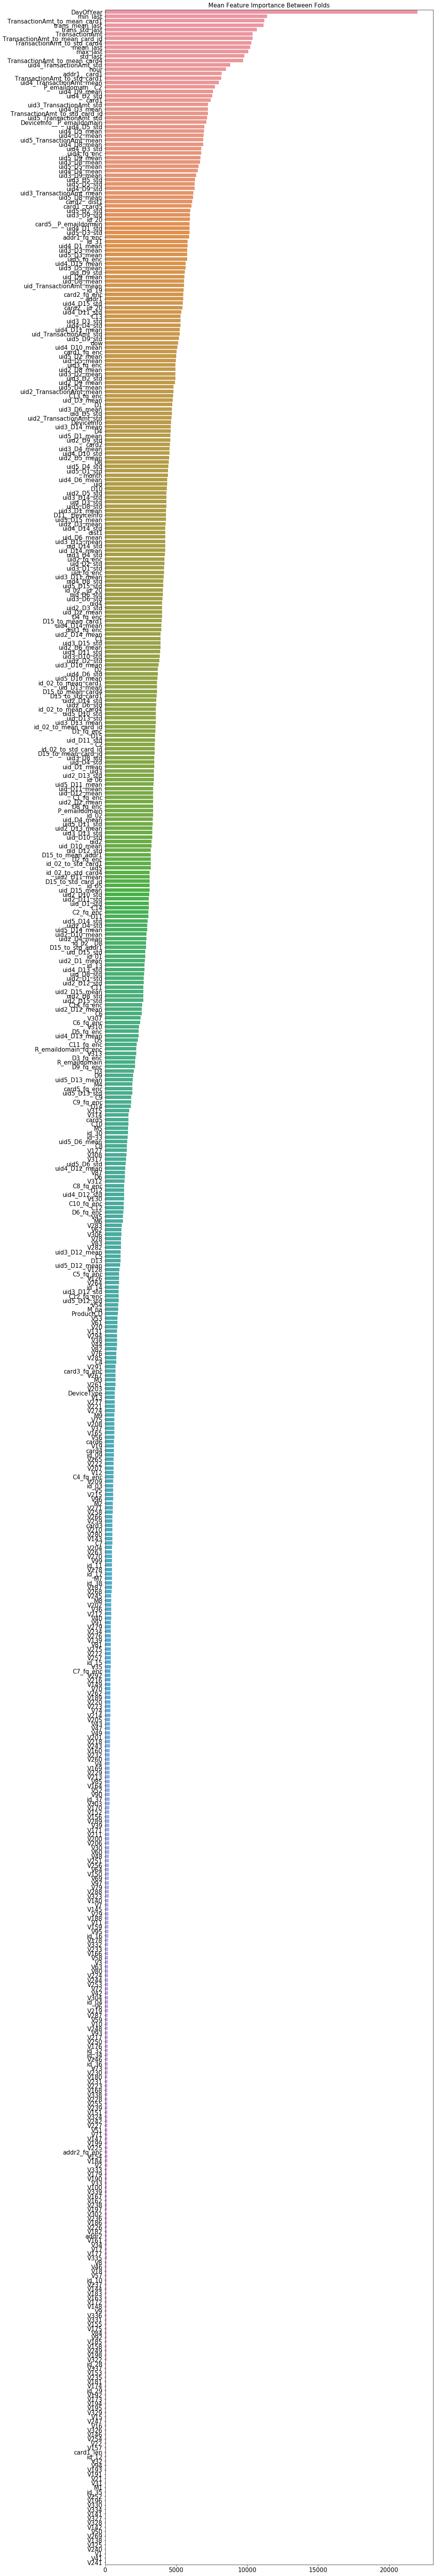

In [37]:
importance['Mean_Importance'] = importance.sum(axis=1) / 5
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 120))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Mean Feature Importance Between Folds', size=15)

plt.show()